# Basic Segmentation and Discrete Binary Structures

<p>

__Quantitative Big Imaging__ ETHZ: 227-0966-00L

    
__Part 2__
    
</p>

<p style="font-size:1em;">March 18, 2021</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

# A Machine Learning Approach to Image Processing

Segmentation and all the steps leading up to it are really a specialized type of learning problem. 

Let's look at an important problem for electron microscopy imaging...

Identifying the mitochondria in the images like the one to the left in the figures below.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread
import plotsupport as ps
%matplotlib inline

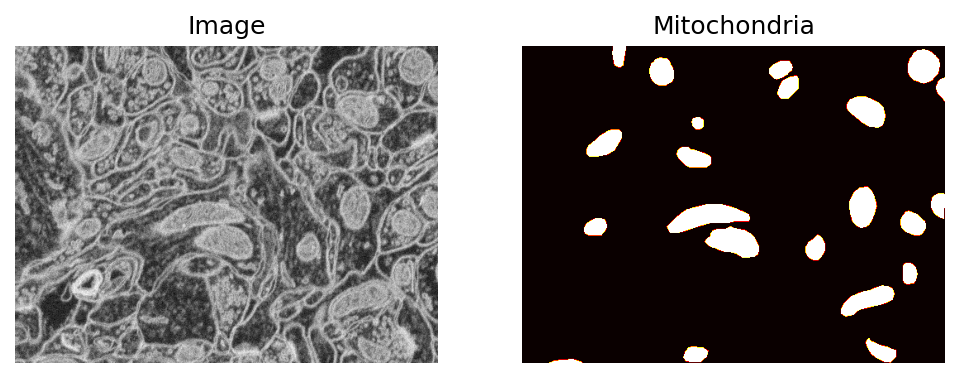

In [3]:
cell_img = (255-imread("data/em_image.png")[::2, ::2])/255.0
cell_seg = imread("data/em_image_seg.png")[::2, ::2]>0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
ax1.imshow(cell_img, cmap='gray'); ax1.set_title('Image');        ax1.axis('off');
ax2.imshow(cell_seg, cmap='hot');  ax2.set_title('Mitochondria'); ax2.axis('off');

We want to identify which class each pixel belongs to.

What does identify mean?
- Classify the pixels in a mitochondria as _Foreground_
- Classify the pixels outside of a mitochondria as _Background_

This is a really tedious task and we want to automatize it. Here, segmentation is a good approach. The question is now how we can achieve this.

# How do we quantify this?

<div class="alert alert-block alert-success">
    
- __True Positive__ values in the mitochondria that are classified as _Foreground_
- __True Negative__ values outside the mitochondria that are classified as _Background_

</div>




<div class="alert alert-block alert-danger">
    
- __False Positive__ values outside the mitochondria that are classified as _Foreground_
- __False Negative__ values in the mitochondria that are classified as _Background_

</div>
We can then apply a threshold to the image to determine the number of points in each category


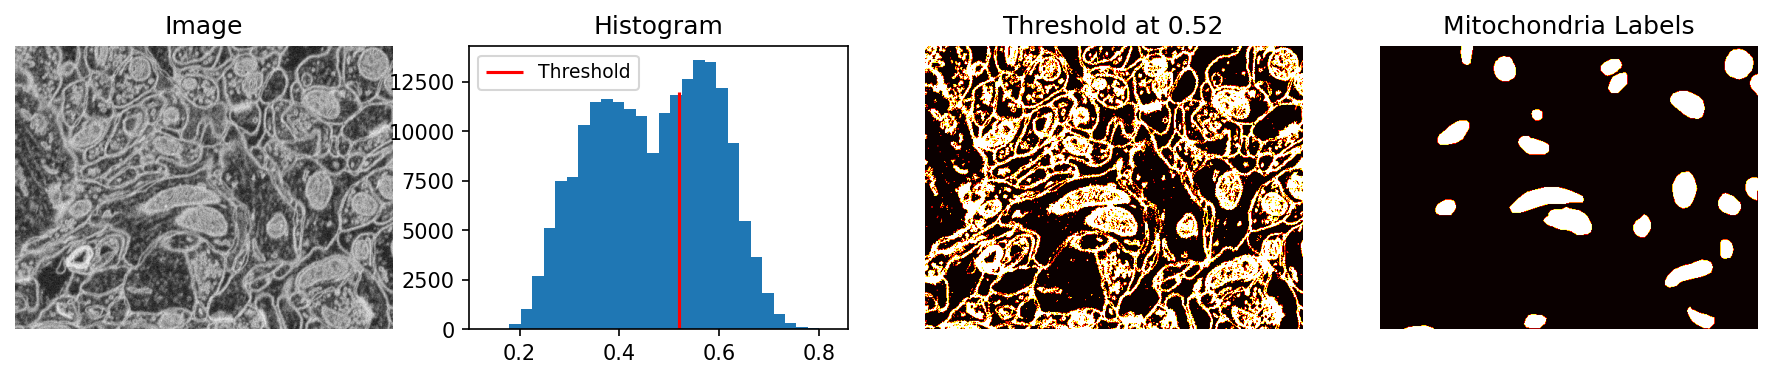

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 2.5), dpi=150)

thresh     = 0.52 
thresh_img = cell_img > thresh # Apply a single threshold to the image

# Visualization
ax[0].imshow(cell_img, cmap='gray');  ax[0].set_title('Image');    ax[0].axis('off')
ax[1].hist(cell_img.ravel(),bins=30); ax[1].set_title('Histogram')
ax[1].vlines(thresh,ymin=0,ymax=12000,color='r',label='Threshold'); ax[1].legend(fontsize=9)
ax[2].imshow(thresh_img, cmap='hot');   ax[2].set_title('Threshold at {0}'.format(thresh)); ax[2].axis('off')
ax[3].imshow(cell_seg,   cmap='hot');   ax[3].set_title('Mitochondria Labels');             ax[3].axis('off');

In this example we can see that it is clearly not sufficient to apply a single threshold as we have tried before. When we compare the thresholded image to the provided mask, we can see the that there are plenty more structures marked as foreground and also that there are holes within the mitochondria.

### Check the performance of the thresholding

Let's create a confusion matrix to visualize the performance of the segmentation. A first step is to compute how many hits and misses our segmentation resulted in. In particual, looking at the four different cases that can occur in a binarization. 

In [27]:
# Suport function for the plot labels
def tp_func(real_img_idx, pred_img_idx):
    if real_img_idx == 1 and pred_img_idx == 1:
        return 'True Positive','#009933'
    if real_img_idx == 0 and pred_img_idx == 0:
        return 'True Negative','#009933'
    if real_img_idx == 0 and pred_img_idx == 1:
        return 'False Positive','#cc0000'
    if real_img_idx == 1 and pred_img_idx == 0:
        return 'False Negative','#cc0000'

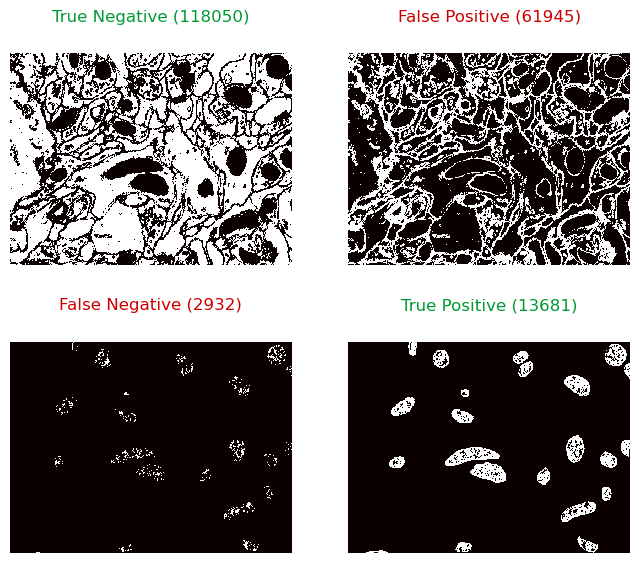

In [28]:
out_results = {}
fig, m_ax = plt.subplots(2, 2, figsize=(8, 7), dpi=100)
for real_img_idx, n_ax in zip([0, 1], m_ax):
    for pred_img_idx, c_ax in zip([0, 1], n_ax):
        match_img = (thresh_img == pred_img_idx) & (cell_seg == real_img_idx)
        (tp_title,color) = tp_func(real_img_idx, pred_img_idx)
        c_ax.matshow(match_img, cmap='hot')
        out_results[tp_title] = np.sum(match_img)
        c_ax.set_title("{0} ({1})".format(tp_title,out_results[tp_title]),color=color)
        c_ax.axis('off')

## The confusion matrix (revisited)

From the counts in the previus slide, we can now create a [Confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) and also look at the combined image of all the cases. In the hit map we can see white and gray as true segmentation and blue and magenta as false segmentations.

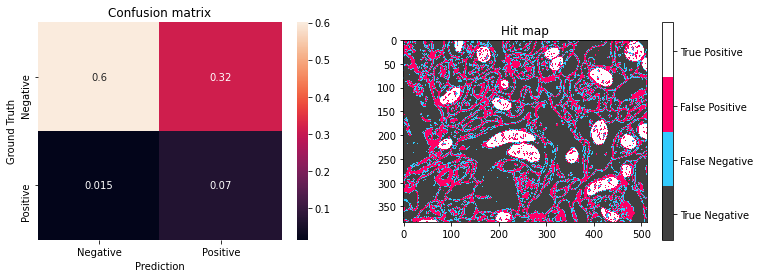

In [29]:
ps.showHitMap(cell_seg,thresh_img) # this is a handy support function provided with the notebook

## Apply Precision and Recall

We can use two further metrics to measure the performance of a segmentation method. These are based on the information in the confusion matrix like

- __Recall__ (sensitivity)  $$\frac{TP}{TP+FN}$$

This is the sum the true positive relative to the number of positives in the mask or also as written here the sum of true positives and false negatives. Recall tells us how good the method is to find the correct label within the mask.

- __Precision__            $$\frac{TP}{TP+FP}$$

This is the sum of true positives relative to the total number of positives provided by our segmentation method. The precision tells us how much our method over segments the image.

Both recall and precision are scalar numbers in the interval $0<m\leq1$ where '1' is the ideal condition.

Let's compute precision and recall for our mitochonria example.

In [27]:
print('Recall: {0:0.2f}'.format(out_results['True Positive'] /
                         (out_results['True Positive']+out_results['False Negative'])))
print('Precision: {0:0.2f}'.format(out_results['True Positive'] /
                            (out_results['True Positive']+out_results['False Positive'])))

Recall: 0.82
Precision: 0.18


This result tells us that our segmentation was relatively good at finding the mitochondria, but also that this happened at the cost of many false positives. 


### [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
Reciever Operating Characteristic ([first developed for WW2 soldiers detecting objects in battlefields using radar](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#History)). 

The ideal is the top-right (identify everything and miss nothing). 

As we saw before, for a single threshold value 0.5, we were able to compute a single recall and precision. 

If we want to make an ROC curve we take a number of threshold values

In [6]:
import pandas as pd
from collections import OrderedDict

out_vals = []
for thresh_val in np.linspace(0.1, 0.9):
    thresh_img = cell_img > thresh_val
    for real_img_idx in [0, 1]:
        for pred_img_idx in [0, 1]:
            match_img = (thresh_img == pred_img_idx) & (
                cell_seg == real_img_idx)
            tp_title = tp_func(real_img_idx, pred_img_idx)
            out_results[tp_title] = np.sum(match_img)
    out_vals += [
        OrderedDict(
            Threshold=thresh_val,
            Recall=out_results['True Positive'] /
            (out_results['True Positive']+out_results['False Negative']),
            Precision=(out_results['True Positive'] /
                       (out_results['True Positive']+out_results['False Positive'])),
            False_Positive_Rate=(out_results['False Positive'] /
                       (out_results['False Positive']+out_results['True Negative'])),
            **out_results
        )]

roc_df = pd.DataFrame(out_vals)
roc_df.head(3)

,Threshold,Recall,Precision,False_Positive_Rate,True Negative,False Positive,False Negative,True Positive,"(True Negative, green)","(False Positive, red)","(False Negative, red)","(True Positive, green)"
0,0.100000,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613
1,0.116327,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613
2,0.132653,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613


# Making ROC Curves Easier
ROC curves are a very common tool for analyzing the performance of binary classification systems and there are a large number of tools which can automatically make them. Here we show how it is done with scikit-image. 

Another way of showing the ROC curve (more common for machine learning rather than medical diagnosis) is using the True positive rate and False positive rate

- __True Positive Rate__ (recall)= $TP/(TP+FN)$
- __False Positive Rate__ = $FP/(FP+TN)$

These show very similar information with the major difference being the goal is to be in the upper left-hand corner. Additionally random guesses can be shown as the slope 1 line. Therefore for a system to be useful it must lie above the random line.

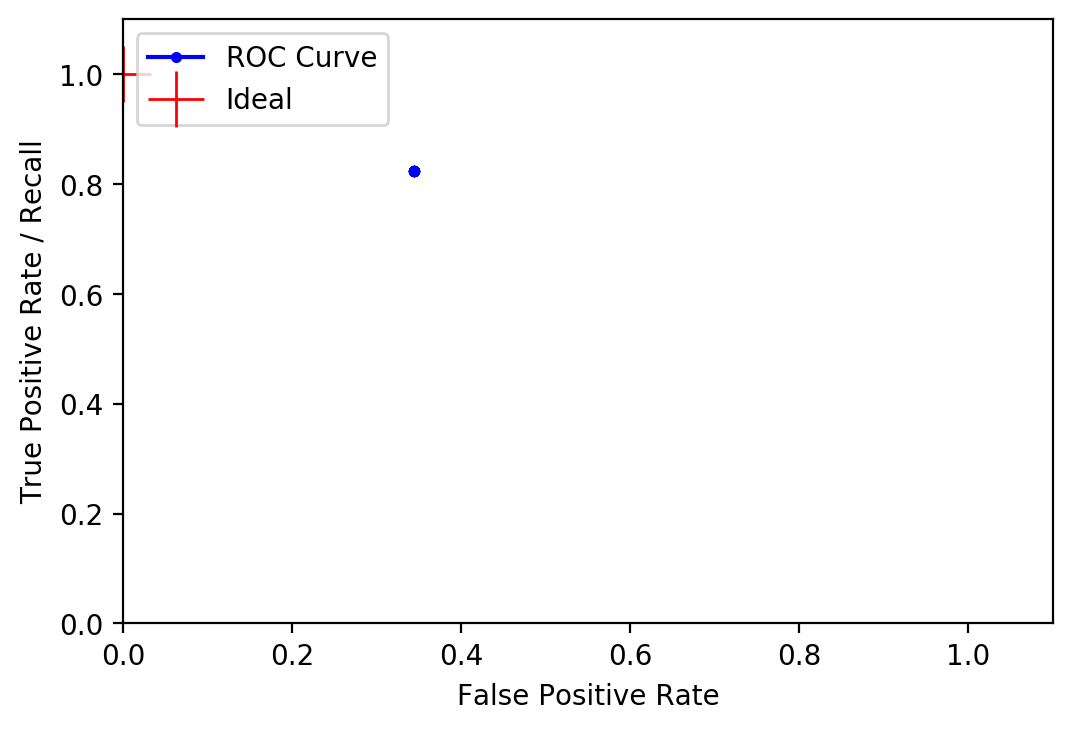

In [7]:
fig, ax1 = plt.subplots(1, 1, dpi=200)
ax1.plot(roc_df['False_Positive_Rate'], roc_df['Recall']  , 'b.-', label='ROC Curve')
ax1.plot(0, 1.0, 'r+', markersize=20, label='Ideal')
ax1.set_xlim(0, 1.1)
ax1.set_ylim(0, 1.1)
ax1.set_ylabel('True Positive Rate / Recall')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc=2)

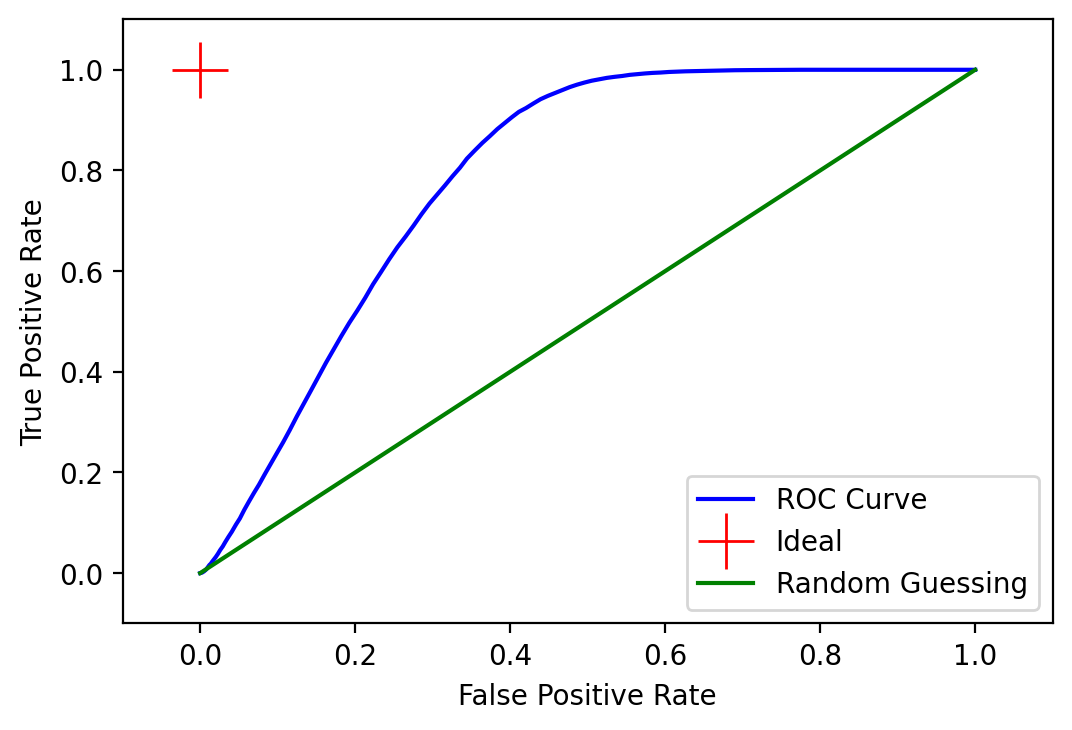

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(cell_seg.ravel().astype(int),
                                 cell_img.ravel())

fig, ax1 = plt.subplots(1, 1, dpi=200)
ax1.plot(fpr, tpr, 'b.-', markersize=0.01,  label='ROC Curve')
ax1.plot(0.0, 1.0, 'r+', markersize=20, label='Ideal')
ax1.plot([0, 1], [0, 1], 'g-', label='Random Guessing')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc=0);

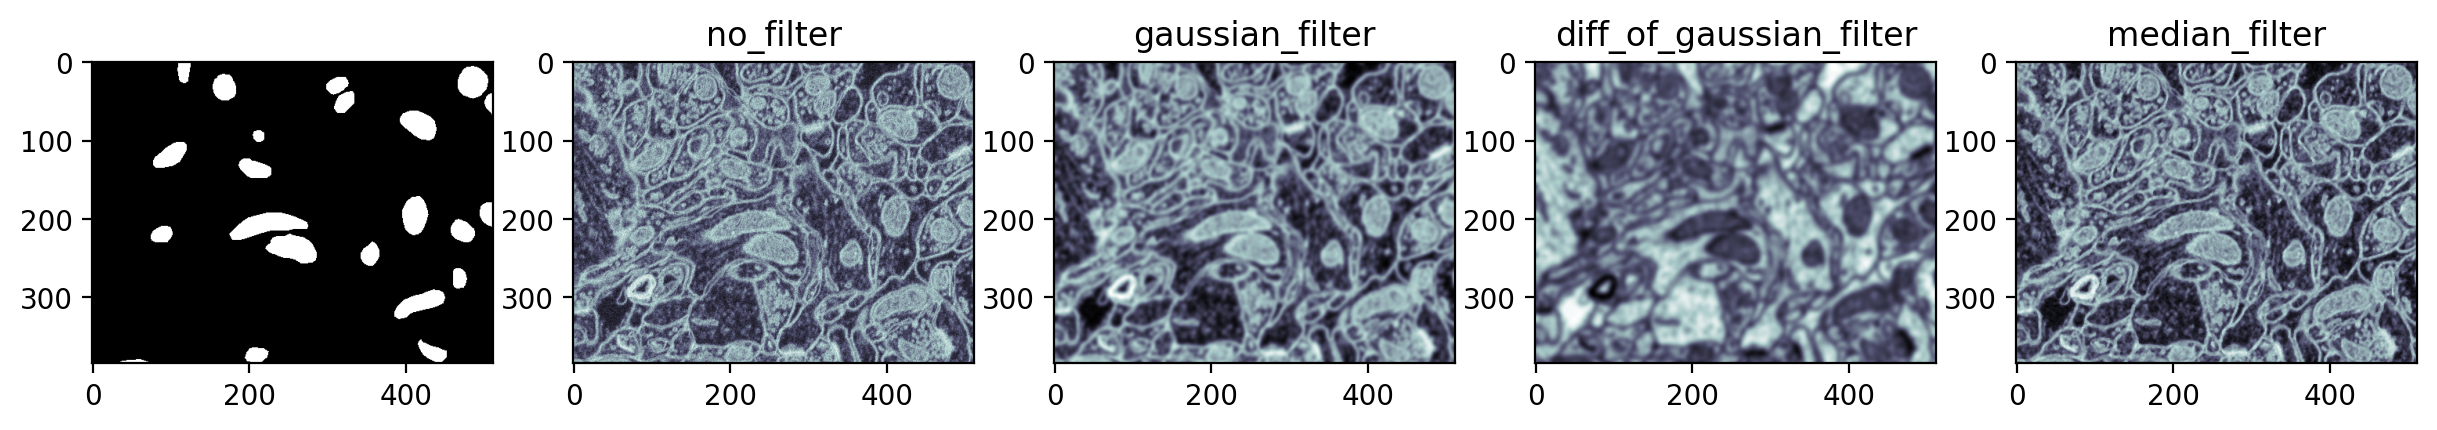

In [29]:
from skimage.filters import gaussian, median


def no_filter(x):
    return x


def gaussian_filter(x):
    return gaussian(x, sigma=2)


def diff_of_gaussian_filter(x):
    return   -gaussian(x, sigma=3)


def median_filter(x):
    return median(x, np.ones((3, 3)))


fig, m_axs = plt.subplots(1, 5, figsize=(15, 3), dpi=200)
m_axs[0].imshow(cell_seg, cmap='gray')
for c_filt, c_ax in zip([no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter], m_axs[1:]):
    c_ax.imshow(c_filt(cell_img), cmap='bone')
    c_ax.set_title(c_filt.__name__)

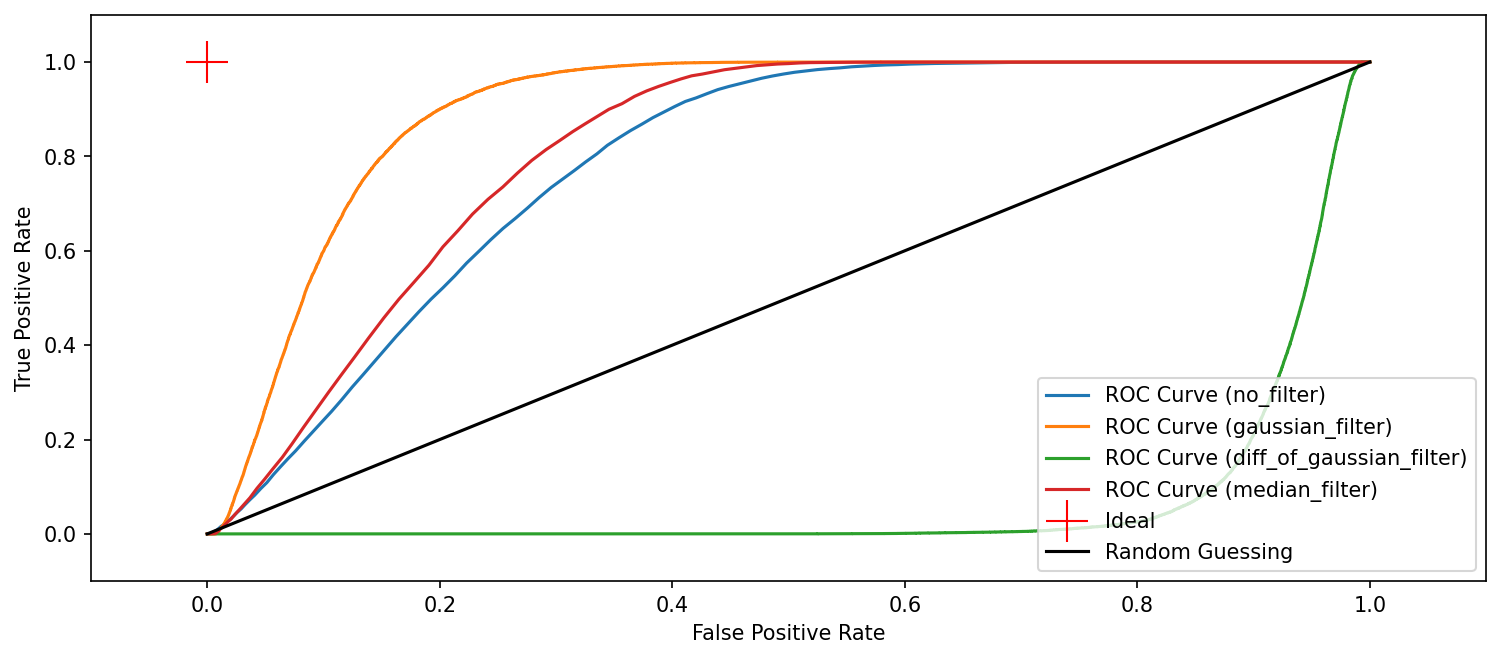

In [34]:
fig, ax1 = plt.subplots(1, 1,figsize=(12,5), dpi=150)
for c_filt in [no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]:
    fpr, tpr, thresholds = roc_curve(cell_seg.ravel().astype(int),
                                     c_filt(cell_img).ravel())
    ax1.plot(fpr, tpr, '-', markersize=0.01,
             label='ROC Curve ({})'.format(c_filt.__name__))

ax1.plot(0.0, 1.0, 'r+', markersize=20, label='Ideal')
ax1.plot([0, 1], [0, 1], 'k-', label='Random Guessing')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize=10);

We can then use this ROC curve to compare different filters (or even entire workflows), if the area is higher the approach is better.

Different approaches can be compared by area under the curve

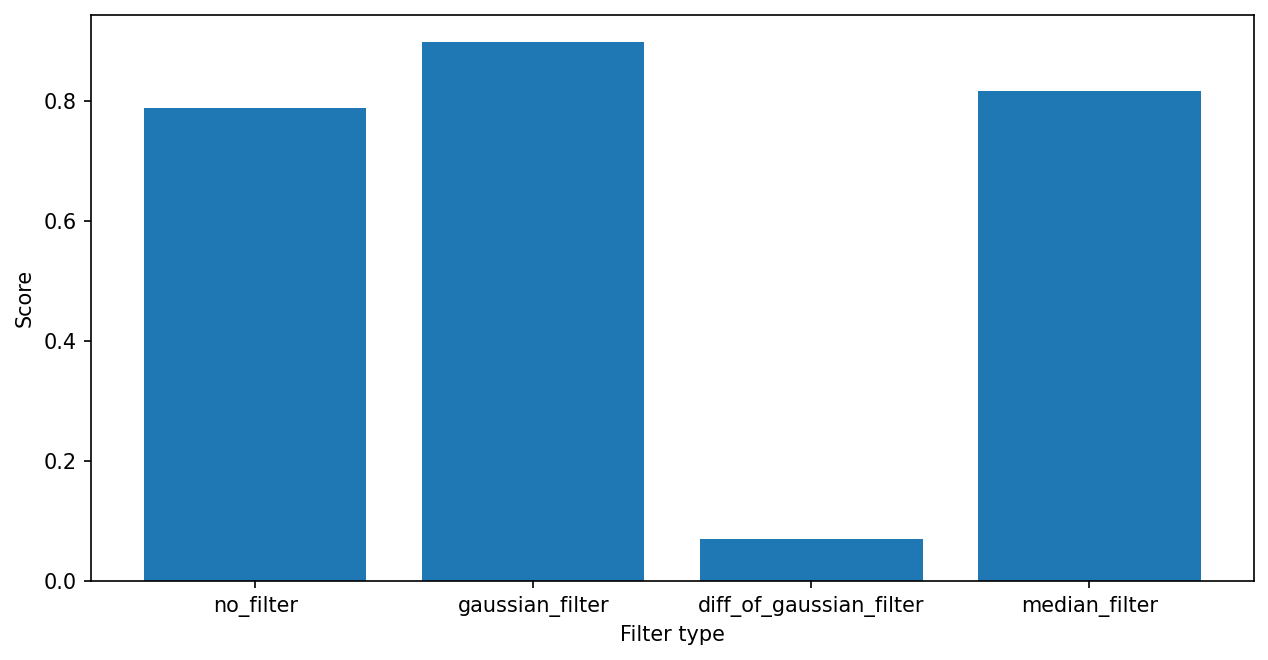

In [35]:
from sklearn.metrics import roc_auc_score
scores = []
names = ['no_filter', 'gaussian_filter', 'diff_of_gaussian_filter', 'median_filter']
for c_filt in [no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]:
    scores.append(roc_auc_score(cell_seg.ravel().astype(int),  c_filt(cell_img).ravel()))
#    print('%s - %2.2f' % (c_filt.__name__, roc_auc_score(cell_seg.ravel().astype(int),
#                                                         c_filt(cell_img).ravel())))
    
plt.figure(figsize=[10,5],dpi=150)
plt.bar(names,scores); plt.xlabel('Filter type'),plt.ylabel('Score');

# Evaluating Models

- https://github.com/jvns/talks/blob/master/pydatanyc2014/slides.md
- http://mathbabe.org/2012/03/06/the-value-added-teacher-model-sucks/

# Multiple Phases: Segmenting Shale

- Shale provided from Kanitpanyacharoen, W. (2012). Synchrotron X-ray Applications Toward an Understanding of Elastic Anisotropy.

- Here we have a shale sample measured with X-ray tomography with three different phases inside (clay, rock, and air).
- The model is that because the chemical composition and density of each phase is different they will absorb different amounts of x-rays and appear as different brightnesses in the image

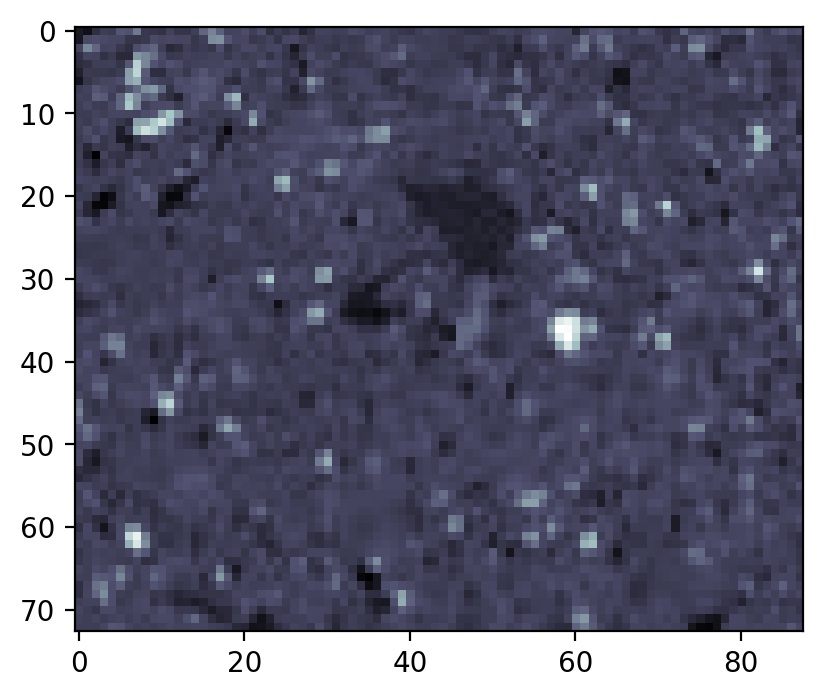

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread
%matplotlib inline
shale_img = imread("figures/ShaleSample.jpg")/255.0
fig, ax1 = plt.subplots(1, 1, dpi=200)
ax1.imshow(shale_img, cmap='bone');

Ideally we would derive 3 values for the thresholds based on a model for the composition of each phase and how much it absorbs, but that is not always possible or practical.
- While there are 3 phases clearly visible in the image, the histogram is less telling (even after being re-scaled).

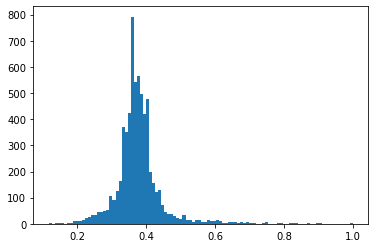

In [40]:
plt.hist(shale_img.ravel(), 100);

# Multiple Segmentations

For this exercise we choose arbitrarily 3 ranges for the different phases and perform visual inspection

The relation can explicitly be written out as
$$ I(x) = 
\begin{cases}
\text{Void}, & 0 \leq x \leq 0.3  \\
\text{Clay}, & 0.3 < x \leq 0.5 \\
\text{Rock}, & 0.5 < x
\end{cases}$$

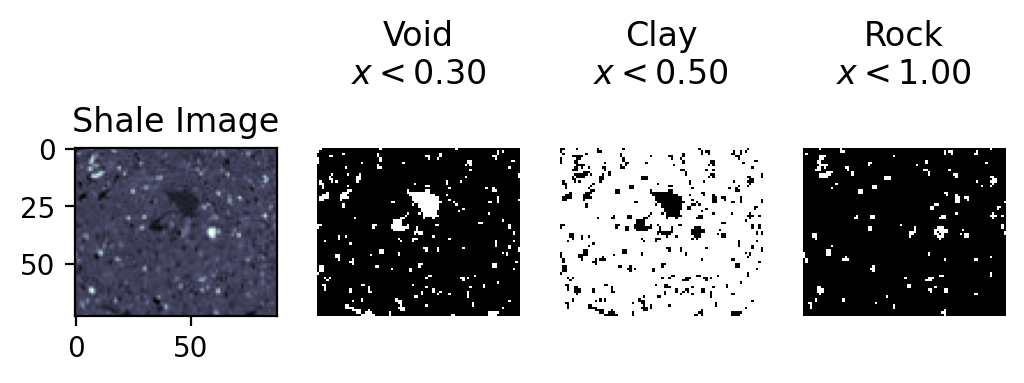

In [41]:
fig, m_axs = plt.subplots(1, 4, dpi=200, figsize=(6, 3))
m_axs[0].imshow(shale_img, cmap='bone')
m_axs[0].set_title('Shale Image')
used_vox = np.zeros_like(shale_img).astype(np.uint8)
for c_ax, c_max, c_title in zip(m_axs[1:], [0.3, 0.5, 1.0], ['Void', 'Clay', 'Rock']):
    c_slice = (shale_img < c_max)-used_vox
    c_ax.matshow(c_slice, cmap='bone')
    used_vox += c_slice
    c_ax.axis('off')
    c_ax.set_title('%s\n$x<%2.2f$' % (c_title, c_max))

# Implementation

The implementations of basic thresholds and segmentations is very easy since it is a unary operation of a single image
$$ f(I(\vec{x})) $$
In mathematical terms this is called a map and since it does not require information from neighboring voxels or images it can be calculated for each point independently (_parallel_). Filters on the other hand almost always depend on neighboring voxels and thus the calculations are not as easy to seperate. 

# Implementation Code 
### Matlab / Python (numpy)
The simplist is a single threshold in Matlab: 
```matlab
thresh_img = gray_img > thresh
```

A more complicated threshold: 
```
thresh_img = (gray_img > thresh_a) & (gray_img < thresh_b)
```


### Python
```python
thresh_img = map(lambda gray_val: gray_val>thresh,
                gray_img)
```

***

### Java
```java
boolean[] thresh_img = new boolean[x_size*y_size*z_size];
for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```
  
### In C/C++

```c
bool* thresh_img = malloc(x_size*y_size*z_size * sizeof (bool));

for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```

# [Morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html)
We can now utilize information from neighborhood voxels to improve the results. These steps are called morphological operations. We return to the original image of a cross

Like filtering the assumption behind morphological operations are
- nearby voxels in __real__ images are related / strongly correlated with one another 
- noise and imaging artifacts are less spatially correlated. 

Therefore these imaging problems can be alleviated by adjusting the balance between local and neighborhood values.

Text(0.5, 1.0, 'Simple Thresholding')

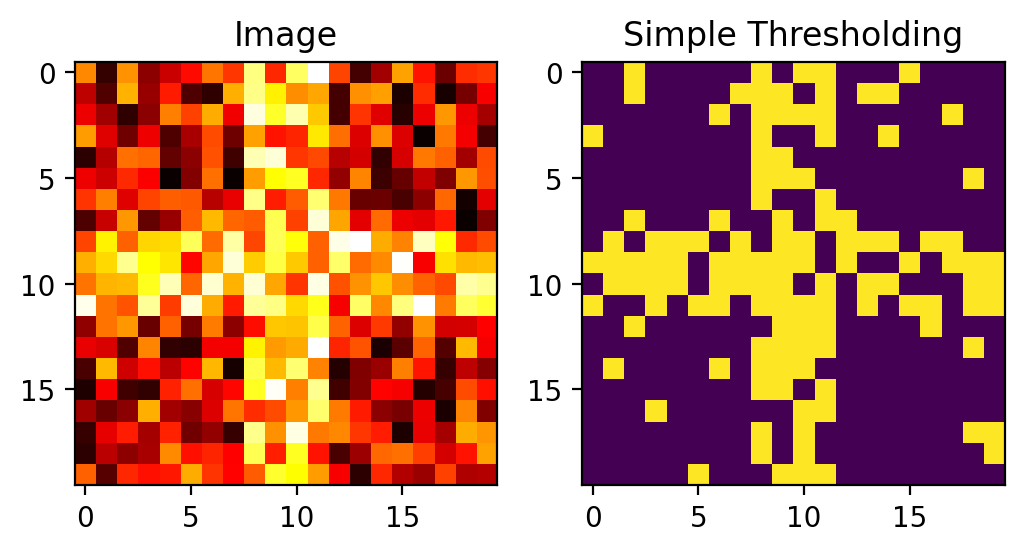

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nx = 20
ny = 20
xx, yy = np.meshgrid(np.linspace(-10, 10, nx),
                     np.linspace(-10, 10, ny))
np.random.seed(2018)
cross_im = 1.1*((np.abs(xx) < 2)+(np.abs(yy) < 2)) + \
    np.random.uniform(-1.0, 1.0, size=xx.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5), dpi=200)
ax1.imshow(cross_im, cmap='hot')
ax1.set_title('Image')
ax2.imshow(cross_im > 0.8)
ax2.set_title('Simple Thresholding')

## Fundamentals: Neighborhood
A neighborhood consists of the pixels or voxels which are of sufficient proximity to a given point. There are a number of possible definitions which largely affect the result when it is invoked.   
- A large neighborhood performs operations over larger areas / volumes
 - Computationally intensive
 - Can _smooth_ out features
- A small neighborhood performs operations over small areas / volumes
 - Computationally cheaper
 - Struggles with large noise / filling large holes

The neighborhood is important for a large number of image and other (communication, mapping, networking) processing operations:
- filtering
- morphological operations
- component labeling
- distance maps
- image correlation based tracking methods

It is often called structuring element (or ```selem``` for sort / code), but has exactly the same meaning

### Fundamentals: Neighbors in 2D

For standard image operations there are two definitions of neighborhood. The 4 and 8 adjacent neighbors shown below. Given the blue pixel in the center the red are the 4-adjacent and the red and green make up the 8 adjacent. We expand beyond this to disk, cross, vertical and horizontal lines

In [50]:
from skimage.morphology import disk, octagon as oct_func, star


def h_line(n):
    return np.pad(np.ones((1, 2*n+1)), [[n, n], [0, 0]], mode='constant', constant_values=0).astype(int)


def v_line(n):
    return h_line(n).T


def cross(n):
    return ((h_line(n)+v_line(n)) > 0).astype(int)


def octagon(n):
    return oct_func(n, n)

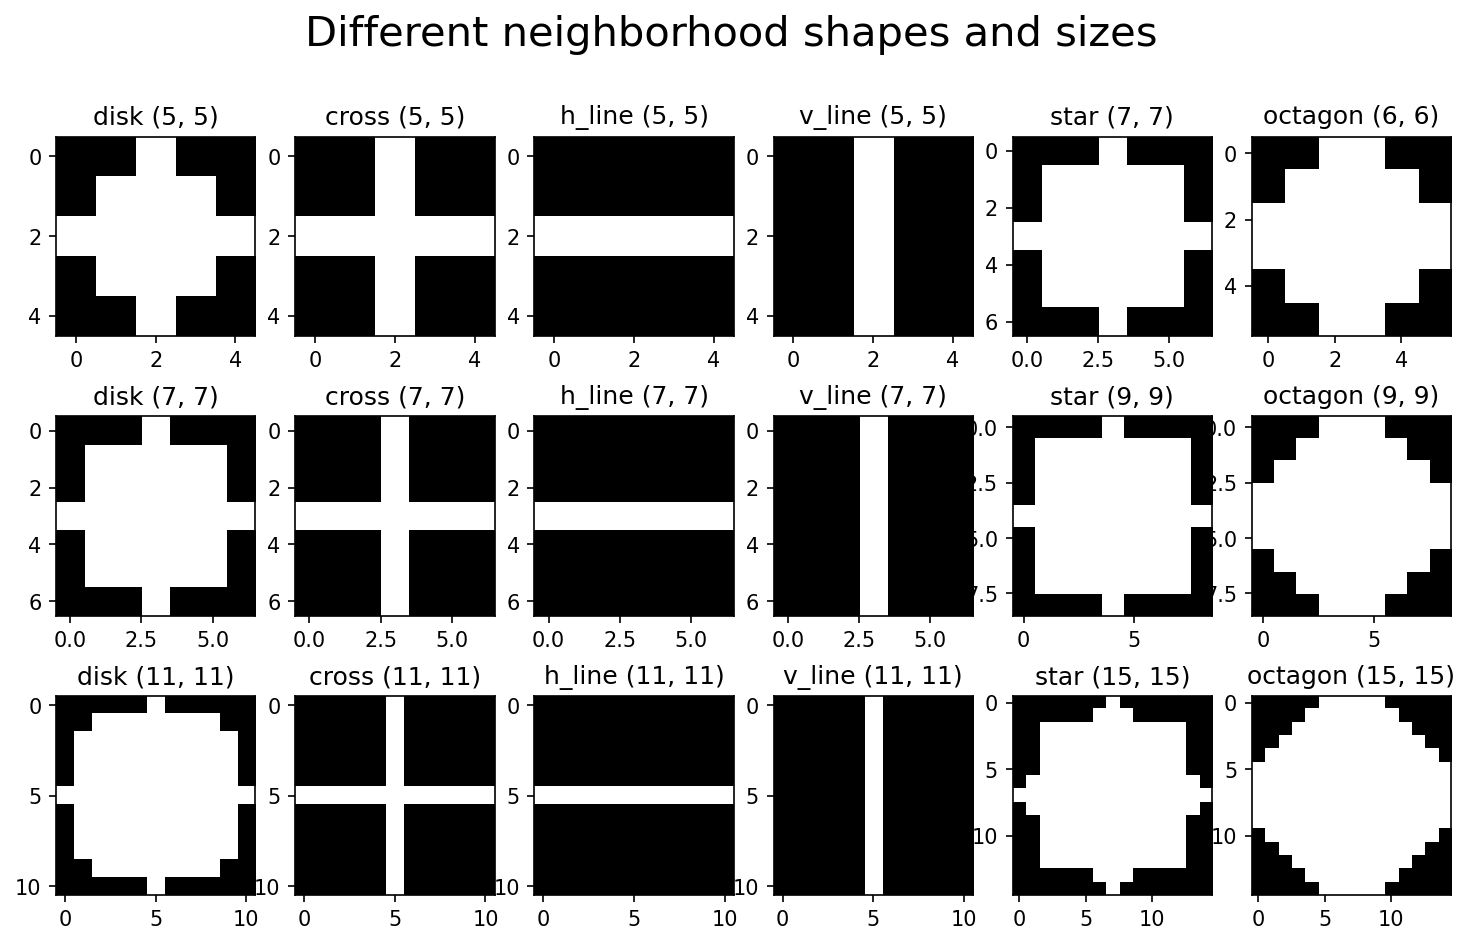

In [60]:
neighbor_functions = [disk, cross, h_line, v_line, star, octagon]
sizes = [2, 3, 5]
fig, m_axs = plt.subplots(len(sizes),len(neighbor_functions),
                           figsize=(12, 7),dpi=150)
for c_dim, c_axs in zip(sizes, m_axs):
    for c_func, c_ax in zip(neighbor_functions, c_axs):
        c_ax.imshow(c_func(c_dim), cmap='bone', interpolation='none')
        c_ax.set_title('{} {}'.format(c_func.__name__, c_func(c_dim).shape))
        
plt.suptitle('Different neighborhood shapes and sizes', fontsize=20);

# Erosion and Dilation

### Erosion
If any of the voxels in the neighborhood are 0/false than the voxel will be set to 0

- Has the effect of peeling the surface layer off of an object

***

### Dilation

If any of the voxels in the neigbhorhood are 1/true then the voxel will be set to 1
- Has the effect of adding a layer onto an object (dunking an strawberry in chocolate, adding a coat of paint to a car)

# Applied Erosion and Dilation

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph

img=np.load('data/morphimage.npy')

oimg=morph.opening(img,np.array([[0,1,0],[1,1,1],[0,1,0]]))
cimg=morph.closing(img,np.array([[0,1,0],[1,1,1],[0,1,0]]))
s=255.0
cmap = [[230/s,230/s,230/s],
        [255/s,176/s,159/s],
        [0.0/s,0.0/s,0.0/s]]

## Dilation
We can use dilation to expand objects, for example a too-low threshold value leading to disconnected components

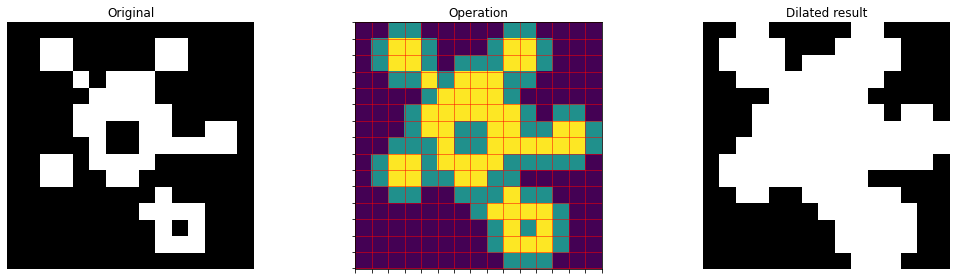

In [84]:
dimg=morph.dilation(img,[[0,1,0],[1,1,1],[0,1,0]])

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(img,cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off');

ax[1].imshow(img+dimg,cmap='viridis'); 
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1)); ax[1].set_xticklabels([]);ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([]) 
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True);ax[1].set_title('Operation')

ax[2].imshow(dimg,cmap='gray'); ax[2].set_title('Dilated result');ax[2].axis('off');
plt.tight_layout()

## Erosion
Erosion performs the opposite task reducing the size

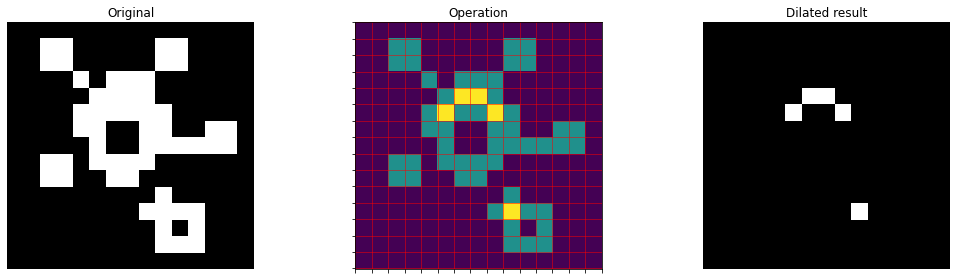

In [85]:
eimg=morph.erosion(img,[[0,1,0],[1,1,1],[0,1,0]])
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(img,cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off');

ax[1].imshow(img+eimg,cmap='viridis'); 
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1)); ax[1].set_xticklabels([]);ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([]) 
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True);ax[1].set_title('Operation')

ax[2].imshow(eimg,cmap='gray'); ax[2].set_title('Dilated result');ax[2].axis('off');
plt.tight_layout()

# Opening and Closing

### Opening

An erosion followed by a dilation operation

- Peels a layer off and adds a layer on
- Very small objects and connections are deleted in the erosion and do not return the image is thus __open__ed
- A cube larger than several voxels will have the exact same volume after (conservative)

***

### Closing

A dilation followed by an erosion operation

- Adds a layer and then peels a layer off
- Objects that are very close are connected when the layer is added and they stay connected when the layer is removed thus the image is __close__d
- A cube larger than one voxel will have the exact same volume after (conservative)

## Morphological Closing 

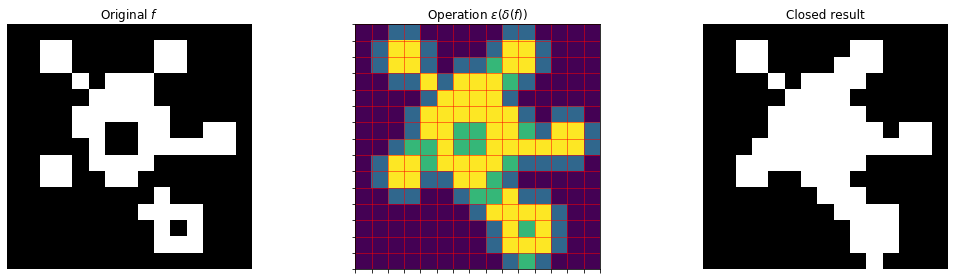

In [24]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Original $f$')
plt.subplot(1,3,2)
plt.imshow(img+dimg+cimg,cmap='viridis')
plt.title('Operation $\epsilon(\delta(f))$')
plt.xticks(np.arange(-0.5,img.shape[1],1),labels=[])
plt.yticks(np.arange(-0.55,img.shape[0],1),labels=[])
plt.grid(color='red', linestyle='-', linewidth=0.5)
plt.grid(True)
plt.subplot(1,3,3)
plt.imshow(cimg,cmap='gray')
plt.title('Closed result')
plt.axis('off')
plt.tight_layout()

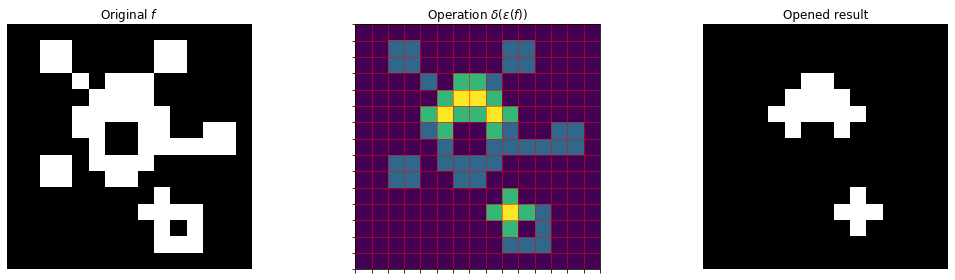

In [25]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Original $f$')
plt.subplot(1,3,2)
plt.imshow(img+eimg+oimg,cmap='viridis')
plt.xticks(np.arange(-0.5,img.shape[1],1),labels=[])
plt.yticks(np.arange(-0.55,img.shape[0],1),labels=[])
plt.grid(color='red', linestyle='-', linewidth=0.5)
plt.grid(True)
plt.title('Operation $\delta(\epsilon(f))$')
plt.subplot(1,3,3)
plt.imshow(oimg,cmap='gray')
plt.axis('off')
plt.title('Opened result')
plt.tight_layout()

# Pitfalls with Segmentation

### Partial Volume Effect
- The [partial volume effect](http://bit.ly/1mW7kdP) is the name for the effect of discretization on the image into pixels or voxels.
- Surfaces are complicated, voxels are simple boxes which make poor representations
- Many voxels are only partially filled, but only the voxels on the surface
- Removing the first layer alleviates issue

### When is a sphere really a sphere?

```{figure} figures/sphere_comparison.pdf
---
scale: 100%
---
Discrete spheres with increasing radius.
```

<img src="figures/sphere_comparison.svg" />  
$$V_{error} = \frac{V_{discrete}}{V_{Analytical}}$$

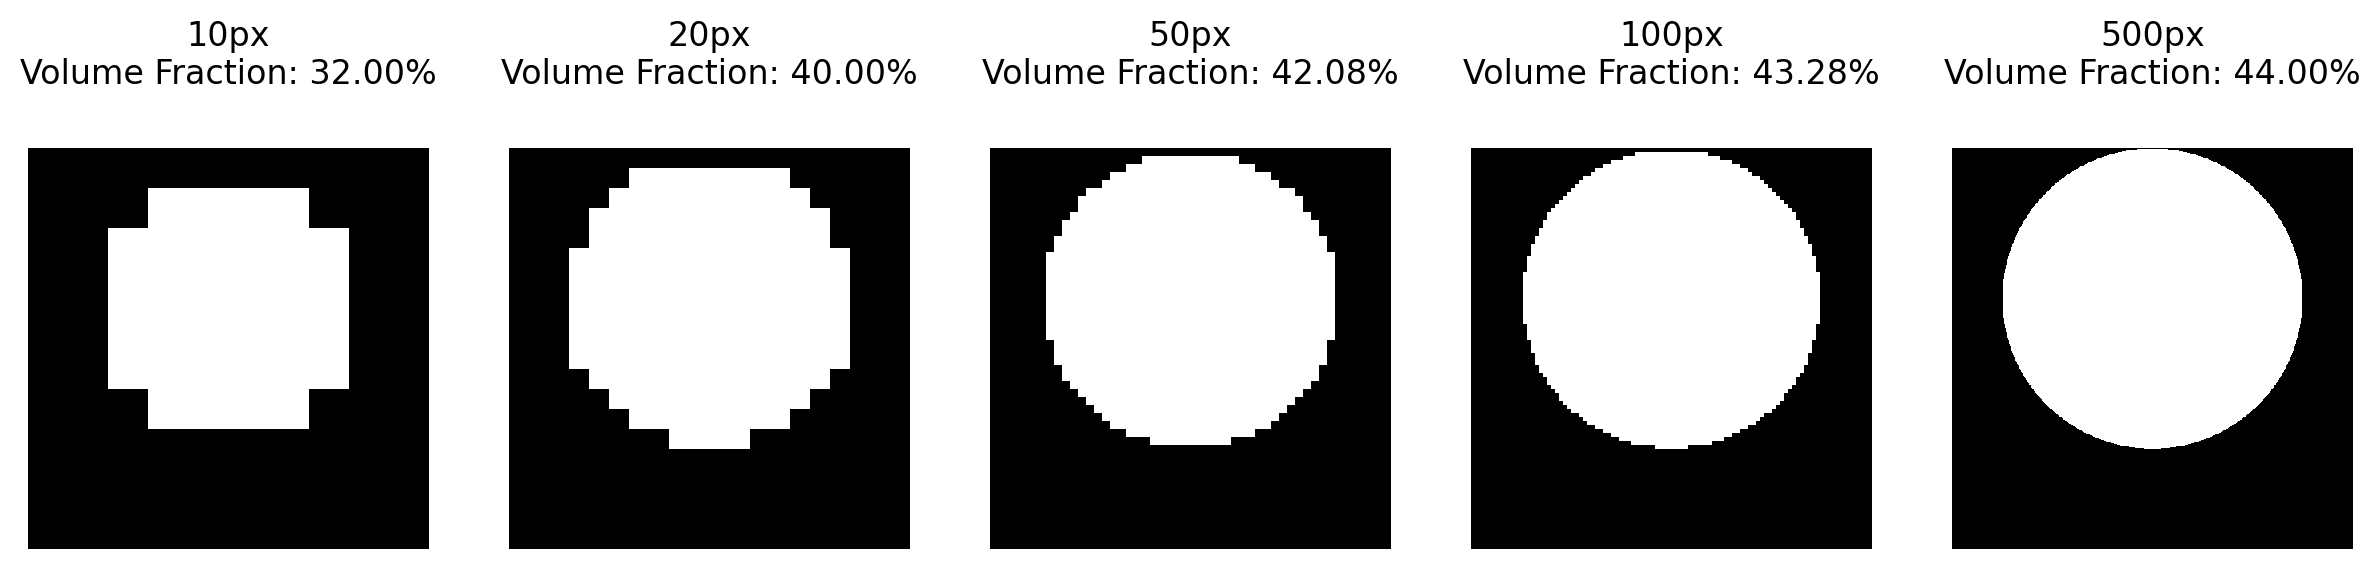

In [87]:
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline
step_list = [10, 20, 50, 100, 500]
fig, m_axs = plt.subplots(1, len(step_list), figsize=(15, 5), dpi=200)
for c_ax, steps in zip(m_axs, step_list):
    x_lin = np.linspace(-1, 1, steps)
    xy_area = np.square(np.diff(x_lin)[0])
    xx, yy = np.meshgrid(x_lin, x_lin)
    test_img = (np.square(xx)+np.square(yy+0.25)) < np.square(0.75)
    c_ax.matshow(test_img,cmap='gray')
    c_ax.set_title('%dpx\nVolume Fraction: %2.2f%%' %
                   (steps, 100*np.sum(test_img)/np.prod(test_img.shape)))
    c_ax.axis('off')

# Rescaling
We see the same effect when we rescale images from 500x500 down to 15x15 that the apparent volume fraction changes 

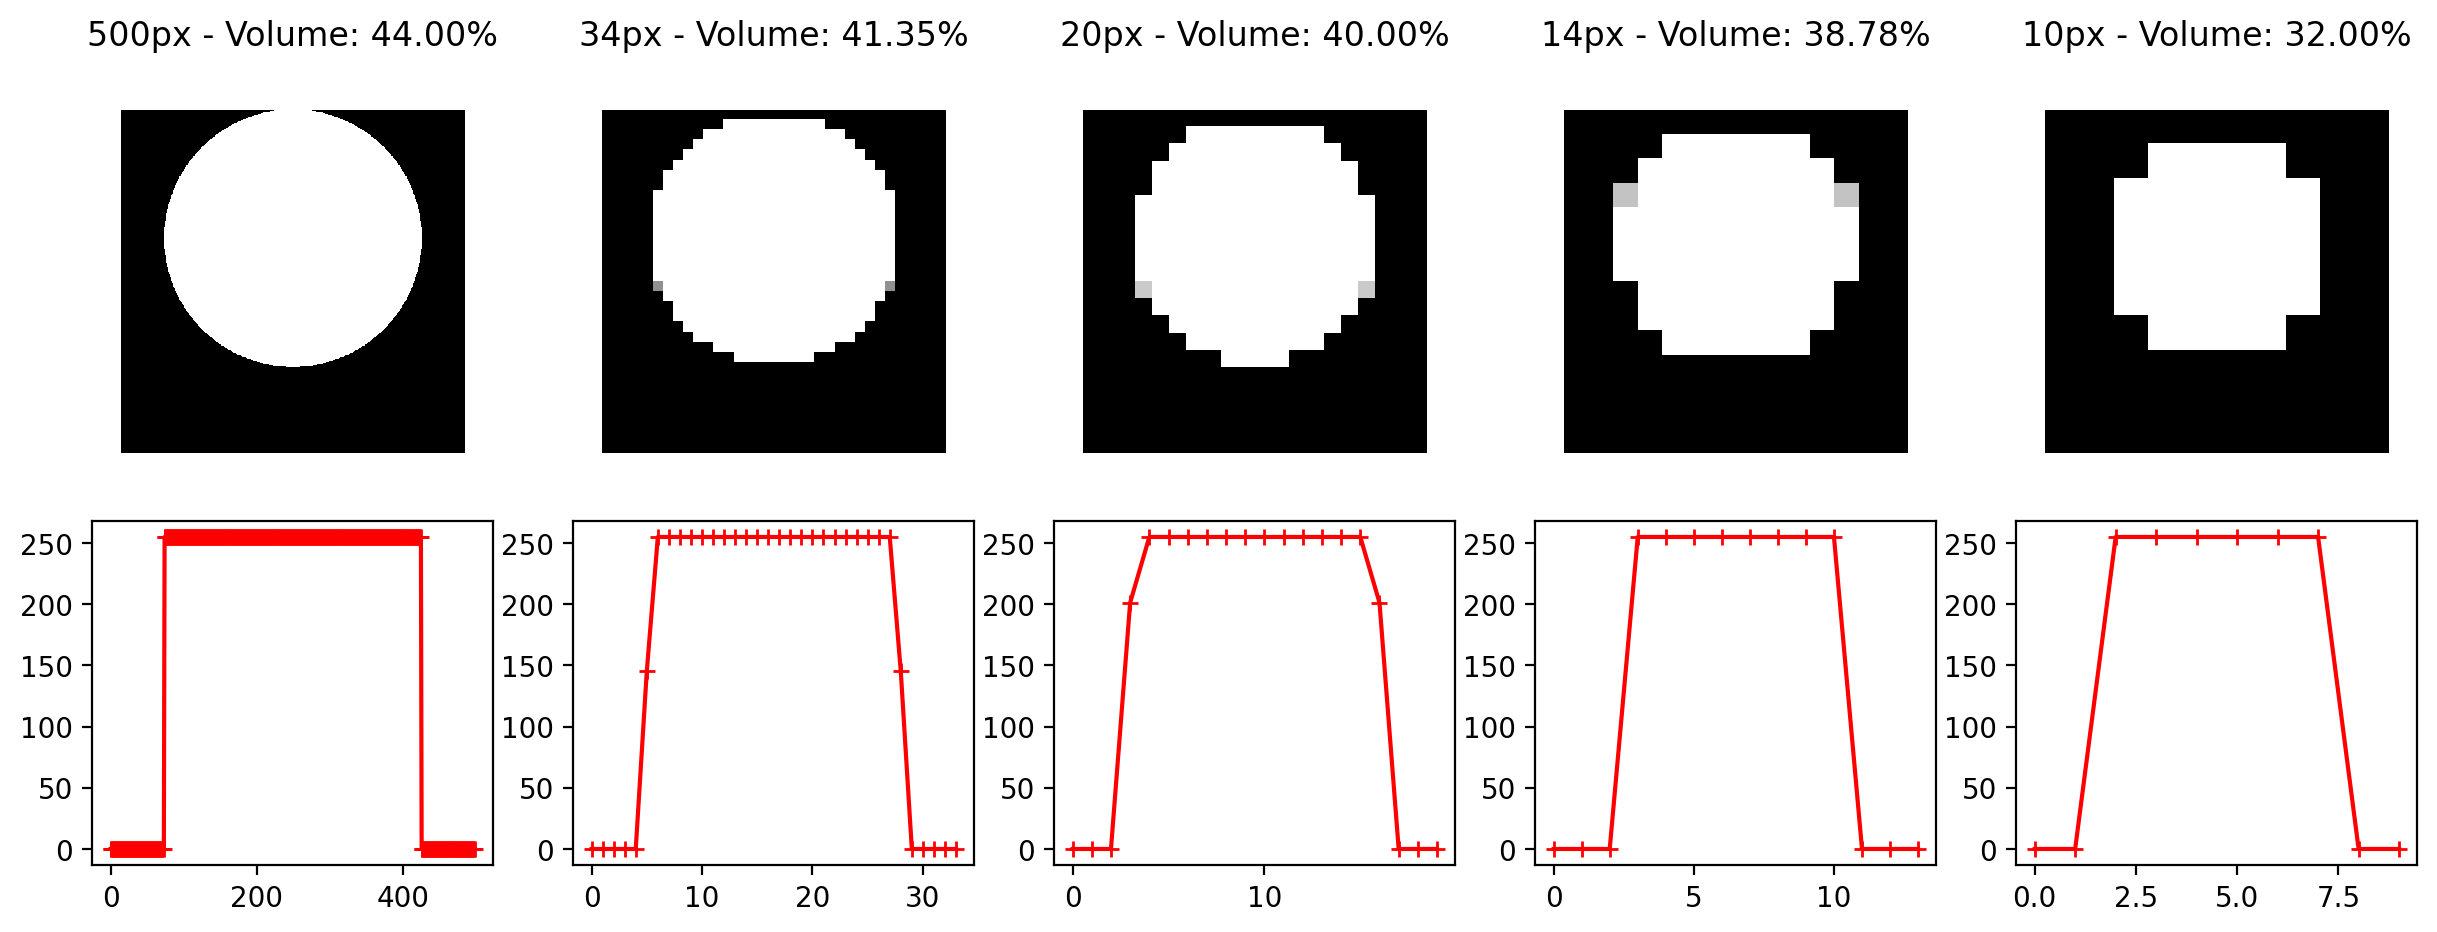

In [88]:
zoom_level = [1, 0.067, 0.039, 0.029, 0.02]
fig, m_axs = plt.subplots(2, len(zoom_level), figsize=(15, 5), dpi=200)
for (c_ax, ax2), c_zoom in zip(m_axs.T, zoom_level):
    c_img = zoom(255.0*test_img, c_zoom, order=1)
    c_ax.matshow(c_img,cmap='gray')
    c_ax.set_title('%dpx - Volume: %2.2f%%' %
                   (c_img.shape[0], 100*np.sum(c_img > 0.5)/np.prod(c_img.shape)))
    c_ax.axis('off')
    ax2.plot(c_img[c_img.shape[0]//2], 'r+-')

# Summary